ファイルを読み込みます: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data/combined_EyeCenterAngle_saccade_analysis_15_4567815161718_umap_nofreq.csv
,区切りファイルとして読み込みます
データ読み込み完了: 177行, 24列
特徴量として使用: 23列
データサイズ: (177, 23)
データの標準化を実行中...
標準化完了
PCAによる次元削減を実行中（次元数: 2）...
PCA完了: 累積寄与率 = 0.6244
PCAの寄与率グラフを保存しました: G:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result\pca_explained_variance.png
IDラベル付きPCAプロットを保存しました: G:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result\pca_with_ids.png
PCA情報付きデータを保存しました: G:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result\pca_data.csv

すべてのグラフを表示します...


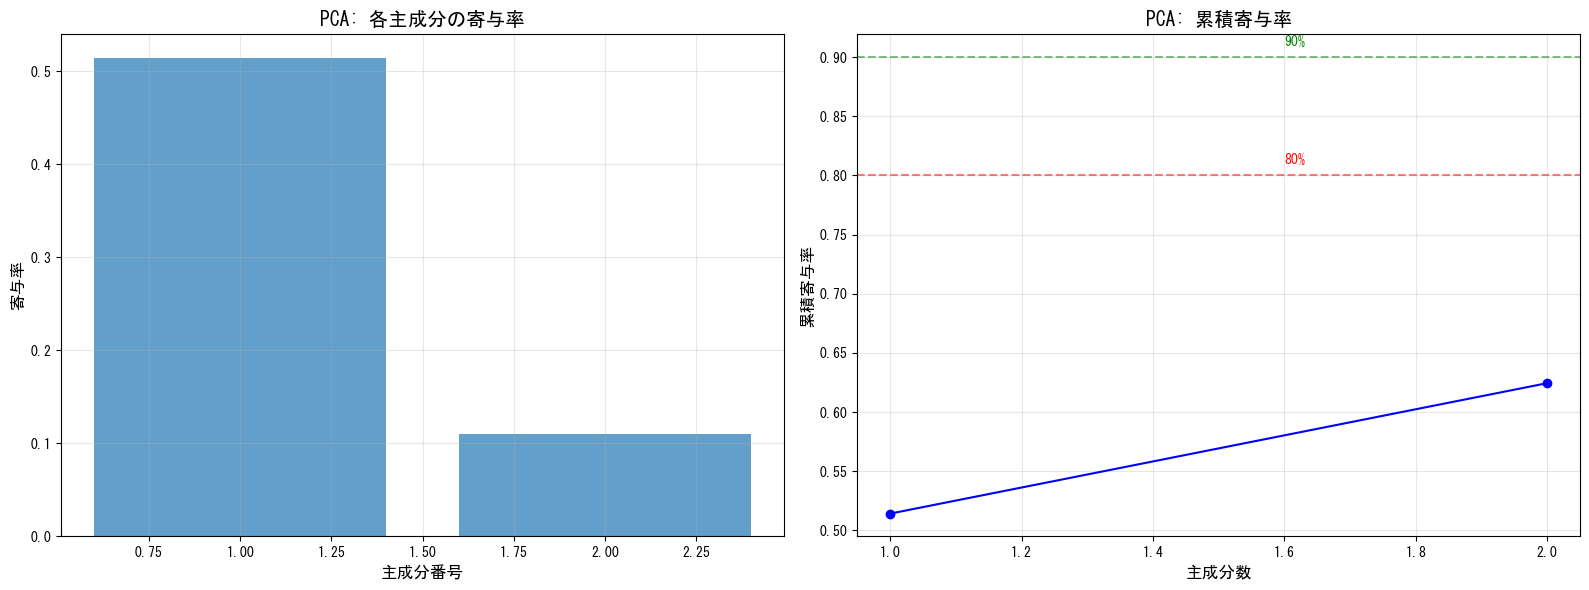

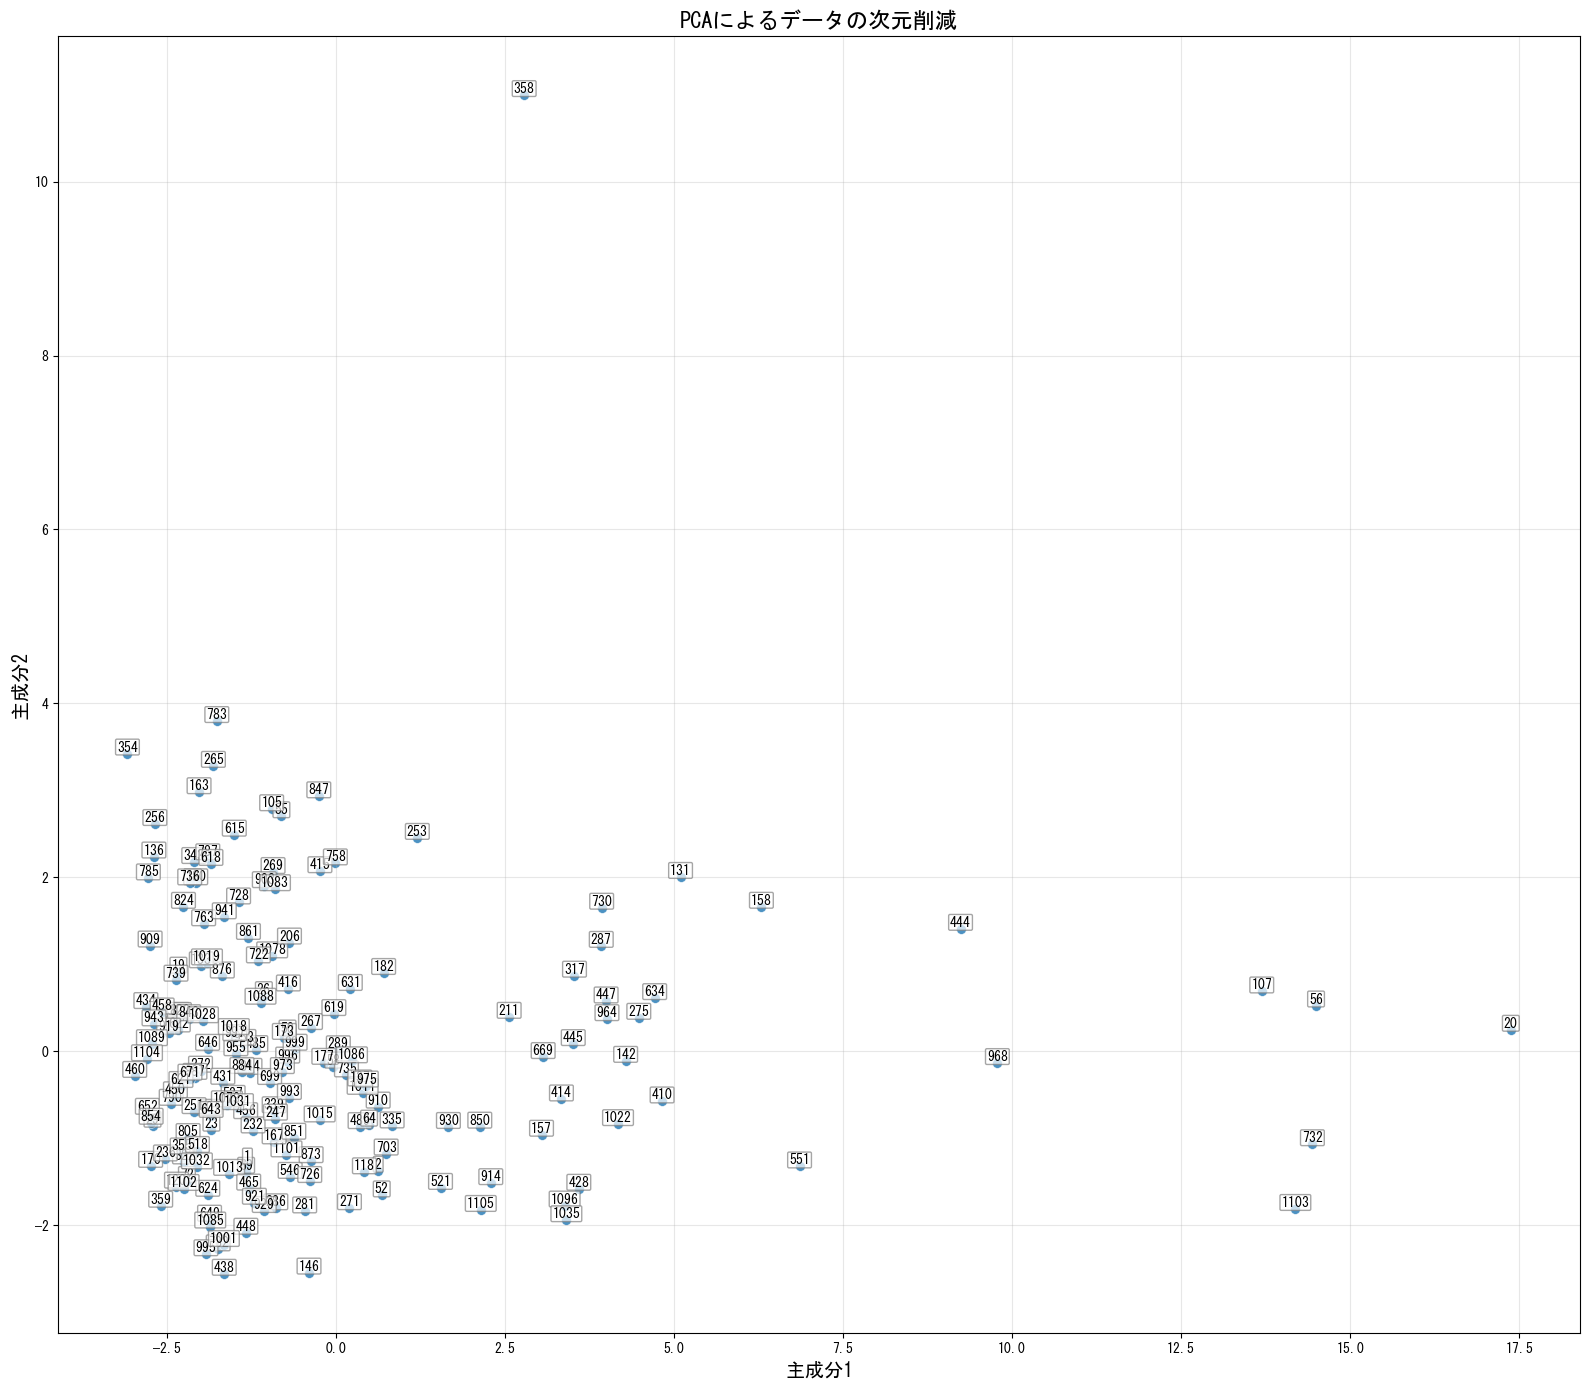

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# ファイルパスの設定
path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data"
file_path = f"{path}/features_test_nolabel.csv"

# 結果を保存するディレクトリ
result_path = r"G:\共有ドライブ\GAP_長寿研\user\iwamoto\視線の動きの俊敏さ\result"
os.makedirs(result_path, exist_ok=True)

# データの読み込み
# データがカンマ区切りの場合はsep=','、タブ区切りの場合はsep='\t'
data = pd.read_csv(file_path, sep=',')

# データの基本情報を確認
print("データのサイズ:", data.shape)
print("カラム名の一部:", data.columns[:10], "...")  # 最初の10カラムのみ表示

# EyeSideとMoCAを除いた数値データのみを特徴量として使用
# 特徴量行列の作成
X = data.drop(['EyeSide', 'MoCA'], axis=1, errors='ignore')

# NaN値の確認と処理
nan_count = X.isna().sum().sum()
print(f"\nNaN値の合計: {nan_count}")
if nan_count > 0:
    print("NaN値を含むカラム:")
    print(X.columns[X.isna().any()].tolist())
    X = X.fillna(X.mean())  # NaN値を平均値で置換

# 特徴量のスケーリング（標準化）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----- K-meansクラスタリング -----

# エルボー法でクラスタ数を決定
inertia = []
k_range = range(1, 11)  # 1から10までのクラスタ数を試す

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# エルボー法のグラフをプロット
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('クラスタ数')
plt.ylabel('慣性（Inertia）')
plt.title('エルボー法によるクラスタ数の決定')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(result_path, 'kmeans_elbow.png'))

# シルエットスコアを計算
silhouette_scores = []
k_range_silhouette = range(2, 11)  # シルエットスコアは少なくとも2クラスタ必要

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"クラスタ数 {k}: シルエットスコア {score:.4f}")

# シルエットスコアのグラフをプロット
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, 'o-')
plt.xlabel('クラスタ数')
plt.ylabel('シルエットスコア')
plt.title('シルエットスコアによるクラスタ数の評価')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(result_path, 'kmeans_silhouette.png'))

# 最適なクラスタ数の決定
# シルエットスコアが最大のクラスタ数を選択
optimal_k = k_range_silhouette[np.argmax(silhouette_scores)]
print(f"\n最適なクラスタ数（シルエットスコア最大）: {optimal_k}")
optimal_k = 4

# 最終的なK-meansモデルを構築
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
cluster_centers = kmeans.cluster_centers_

# クラスタラベルとデータを結合
clustered_data = data.copy()
clustered_data['Cluster'] = cluster_labels

# ----- 可視化と分析 -----

# クラスタごとのサンプル数を計算
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("\nクラスタごとのサンプル数:")
for cluster, count in cluster_counts.items():
    print(f"クラスタ {cluster}: {count} サンプル")

# クラスタごとのサンプル割合を円グラフで表示
plt.figure(figsize=(10, 8))
plt.pie(cluster_counts, labels=[f'クラスタ {i}' for i in cluster_counts.index], 
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('クラスタごとのサンプル割合')
plt.tight_layout()
plt.savefig(os.path.join(result_path, 'kmeans_cluster_distribution.png'))

# MoCAスコアがある場合、クラスタごとのMoCA分布を分析
if 'MoCA' in data.columns:
    # クラスタごとのMoCA統計
    moca_by_cluster = clustered_data.groupby('Cluster')['MoCA'].describe()
    print("\nクラスタごとのMoCA統計:")
    print(moca_by_cluster)
    
    # クラスタごとのMoCA分布をボックスプロットで可視化
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Cluster', y='MoCA', data=clustered_data)
    plt.title('クラスタごとのMoCAスコア分布')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path, 'kmeans_moca_by_cluster.png'))
    
    # MoCAとクラスタのクロス集計表
    moca_cluster_cross = pd.crosstab(
        clustered_data['MoCA'], 
        clustered_data['Cluster'], 
        normalize='index'
    ) * 100  # パーセンテージに変換
    
    print("\nMoCAとクラスタのクロス集計（%）:")
    print(moca_cluster_cross)
    
    # ヒートマップで可視化
    plt.figure(figsize=(10, max(8, len(moca_cluster_cross) * 0.4)))
    sns.heatmap(moca_cluster_cross, annot=True, cmap='YlGnBu', fmt='.1f')
    plt.title('MoCAスコアとクラスタの関係（%）')
    plt.tight_layout()
    plt.savefig(os.path.join(result_path, 'kmeans_moca_cluster_heatmap.png'))

# EyeSideがある場合、クラスタとEyeSideの関係を分析
if 'EyeSide' in data.columns:
    # クラスタとEyeSideのクロス集計
    eyeside_cluster_cross = pd.crosstab(
        clustered_data['Cluster'], 
        clustered_data['EyeSide'], 
        normalize='index'
    ) * 100  # パーセンテージに変換
    
    print("\nクラスタとEyeSideのクロス集計（%）:")
    print(eyeside_cluster_cross)
    
    # クラスタとEyeSideの関係を積み上げ棒グラフで可視化
    plt.figure(figsize=(10, 6))
    eyeside_cluster_cross.plot(kind='bar', stacked=True)
    plt.title('クラスタごとのEyeSide割合')
    plt.xlabel('クラスタ')
    plt.ylabel('割合 (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path, 'kmeans_eyeside_by_cluster.png'))

# クラスタ中心点を元の特徴量スケールに戻す
cluster_centers_original = scaler.inverse_transform(cluster_centers)

# クラスタごとの特徴プロファイル
cluster_profiles = pd.DataFrame(
    cluster_centers_original,
    columns=X.columns,
    index=[f'クラスタ_{i}' for i in range(optimal_k)]
)

print("\nクラスタ中心点（元のスケール）:")
print(cluster_profiles)

# クラスタ中心点をヒートマップで可視化
plt.figure(figsize=(20, max(8, optimal_k)))
sns.heatmap(cluster_profiles, annot=False, cmap='coolwarm', center=0, yticklabels=cluster_profiles.index)
plt.title('各クラスタの特徴プロファイル')
plt.tight_layout()
plt.savefig(os.path.join(result_path, 'kmeans_cluster_profiles.png'))

# クラスタごとの特徴量分布を箱ひげ図で可視化（特徴量が多い場合は一部のみ）
n_features_to_show = min(10, X.shape[1])  # 表示する特徴量の数（最大10個）
selected_features = X.columns[:n_features_to_show]  # 最初のn個の特徴を選択

for feature in selected_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Cluster', y=feature, data=clustered_data)
    plt.title(f'クラスタごとの{feature}分布')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path, f'kmeans_{feature}_by_cluster.png'))

# ----- 結果の保存 -----
# クラスタラベル付きデータをCSVに保存
result_csv_path = os.path.join(result_path, 'kmeans_results.csv')
clustered_data.to_csv(result_csv_path, index=False)
print(f"\nクラスタリング結果を{result_csv_path}に保存しました")

# クラスタプロファイルをCSVに保存
profile_csv_path = os.path.join(result_path, 'kmeans_cluster_profiles.csv')
cluster_profiles.to_csv(profile_csv_path)
print(f"クラスタプロファイルを{profile_csv_path}に保存しました")

print("\nK-meansクラスタリングが完了しました。")